In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import datetime as date
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

C:\Users\User\anaconda3\envs\pythonProject\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
%matplotlib inline

STEP 1: Data Cleaning & Formatting

In [3]:
def format_data(dataset):
    if 'EventTime' in dataset.columns:
        dataset['EventTime'] = pd.to_datetime(dataset['EventTime'])
    if 'Class' in dataset.columns:
        dataset['Class'] = dataset['Class'].fillna('O').astype(str)
    return dataset

In [4]:
trainingData = format_data(pd.read_csv('training.csv'))


In [5]:
testingData = format_data(pd.read_csv('testing.csv'))

In [6]:
def sum_stats(trainSummary, testSummary):
    return "Summary Statistics:\n"\
        'Training Summary', trainSummary.describe(),\
        'Tesing Summary:', testSummary.describe()

sum_stats(trainingData, testingData)

('Summary Statistics:\nTraining Summary',
                            EventTime       Measure
 count                          25000  25000.000000
 mean   2020-11-12 16:05:16.799999744    386.876760
 min              2020-08-17 18:30:00      1.000000
 25%              2020-09-30 04:07:30    315.000000
 50%              2020-11-12 13:45:00    375.000000
 75%              2020-12-26 03:22:30    450.000000
 max              2021-02-07 19:00:00   1000.000000
 std                              NaN    104.100969,
 'Tesing Summary:',
                            EventTime      Measure
 count                           8011  8011.000000
 mean   2021-03-07 16:26:00.479341056   548.587317
 min              2021-02-07 19:10:00   165.000000
 25%              2021-02-21 17:55:00   476.000000
 50%              2021-03-07 16:30:00   554.000000
 75%              2021-03-21 15:15:00   613.000000
 max              2021-04-04 13:00:00  1104.000000
 std                              NaN    99.514687)

In [7]:
def sum_analysis(trainData, testData):
    return "DATA-TYPES:\n" \
        'Training:', trainData.dtypes, \
        'Testing:', testData.dtypes, \
    "Uniques: \n" \
        'Training:', trainData.nunique(), \
        'Testing:', testingData.nunique()
dataGlance = sum_analysis(trainingData, testingData)
dataGlance

('DATA-TYPES:\nTraining:',
 EventTime    datetime64[ns]
 Measure               int64
 Class                object
 dtype: object,
 'Testing:',
 EventTime    datetime64[ns]
 Measure               int64
 Class                object
 dtype: object,
 'Uniques: \nTraining:',
 EventTime    25000
 Measure        754
 Class            2
 dtype: int64,
 'Testing:',
 EventTime    8011
 Measure       564
 Class           2
 dtype: int64)

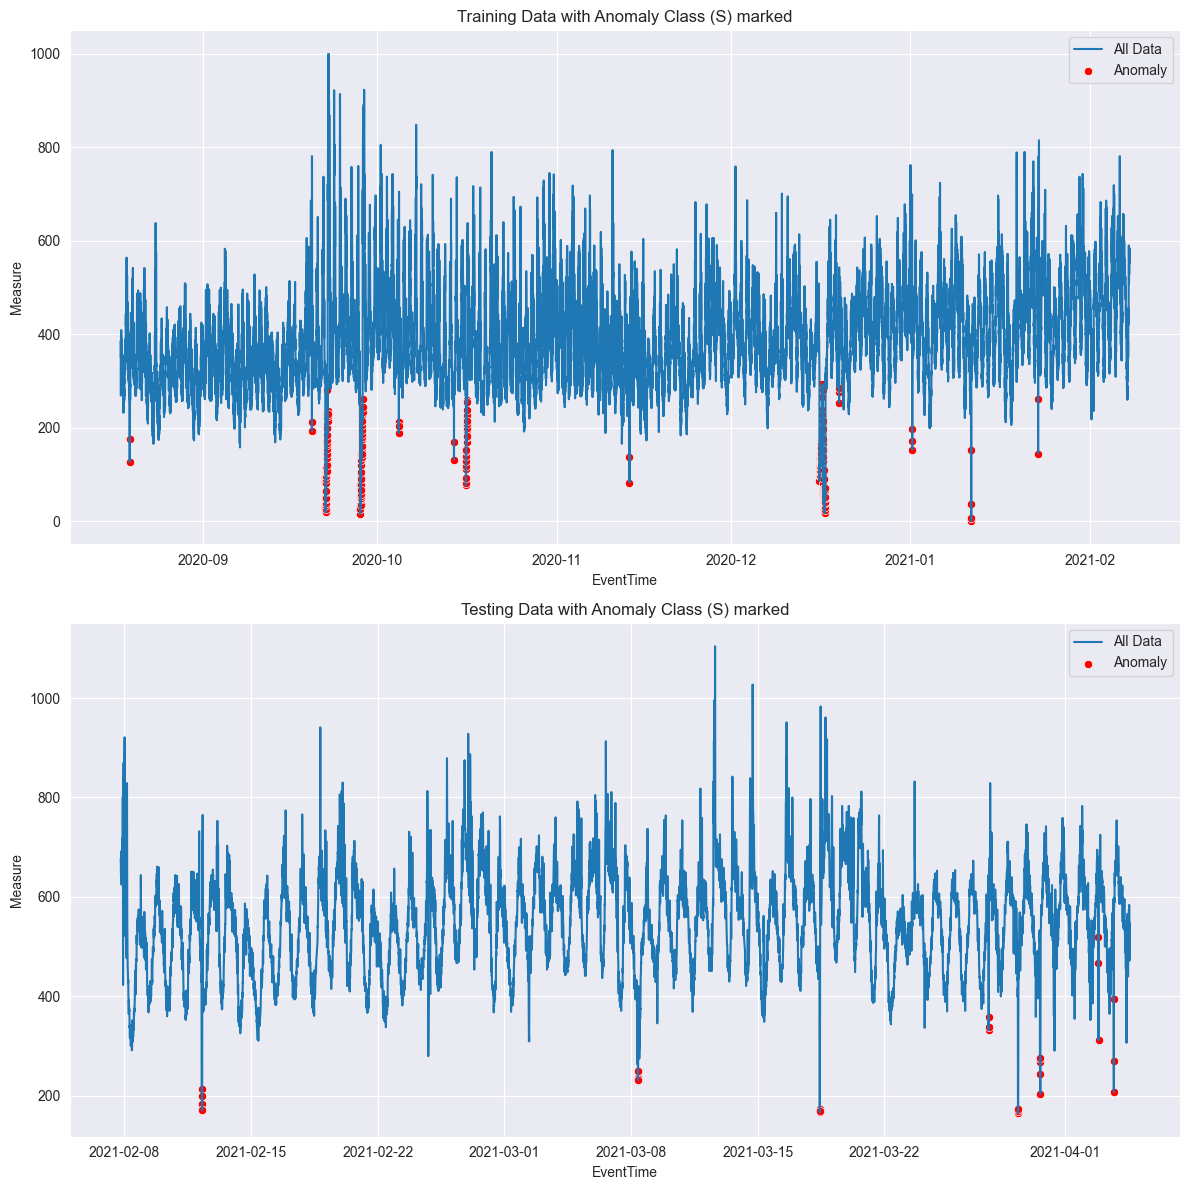

In [8]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
# Plot the entire dataset
sns.lineplot(data=trainingData, x='EventTime', y='Measure', ax=ax1, label='All Data')

# Subset Plotting
'''Training Graph'''
condition_met_data = trainingData[trainingData['Class'] == 'S']
sns.scatterplot(data=condition_met_data, x='EventTime', y='Measure', ax=ax1, label='Anomaly', color='red', markers=True)
sns.lineplot(data=testingData, x='EventTime', y='Measure', ax=ax2, label='All Data')
ax1.set_title('Training Data with Anomaly Class (S) marked')
'''Testing Graph'''
condition_met_data2 = testingData[testingData['Class'] == 'S']
sns.scatterplot(data=condition_met_data2, x='EventTime', y='Measure', ax=ax2, label='Anomaly', color='red', markers=True)
ax2.set_title('Testing Data with Anomaly Class (S) marked')


plt.tight_layout()
plt.show()

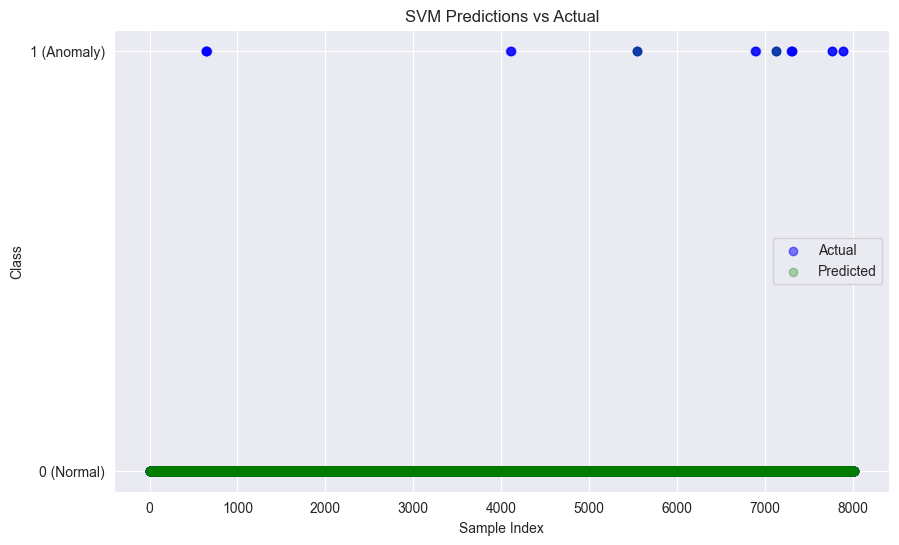

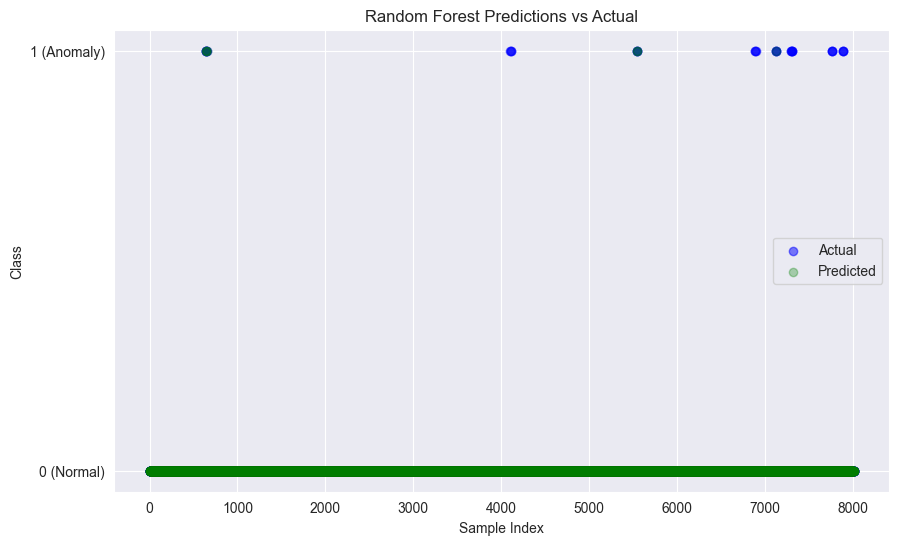

In [149]:
def plot_predictions_scatter(y_true, y_pred, title='Predictions vs Actual'):
    plt.figure(figsize=(10,6))

    # Scatter plot
    plt.scatter(range(len(y_true)), y_true, color='blue', alpha=0.5, label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, color='green', alpha=0.3, label='Predicted')

    plt.title(title)
    plt.ylabel('Class')
    plt.xlabel('Sample Index')
    plt.yticks([0, 1], ['0 (Normal)', '1 (Anomaly)'])
    plt.legend()
    plt.grid(True)
    plt.show()


Z - Score Calculation (Raw Datasets, with PrePros)

In [150]:
""" Z_score """
trainingArray =  np.array([i for i in trainingData.iloc[:, 1]])
trainingArray

scaler = StandardScaler()
z_scores = scaler.fit_transform(trainingArray.reshape(-1, 1))
z_scores

trainingData['z_scores'] = scaler.fit_transform(trainingData['Measure'].values.reshape(-1, 1))
trainingData

,EventTime,Measure,Class,z_scores
0,2020-08-17 18:30:00,269,0.0,-1.132354
1,2020-08-17 18:40:00,380,0.0,-0.066060
2,2020-08-17 18:50:00,386,0.0,-0.008422
3,2020-08-17 19:00:00,376,0.0,-0.104485
4,2020-08-17 19:10:00,374,0.0,-0.123697
...,...,...,...,...
24995,2021-02-07 18:20:00,568,0.0,1.739915
24996,2021-02-07 18:30:00,570,0.0,1.759128
24997,2021-02-07 18:40:00,564,0.0,1.701490
24998,2021-02-07 18:50:00,583,0.0,1.884009


In [151]:
testingArray =  np.array([i for i in testingData.iloc[:, 1]])
testingArray

scaler = StandardScaler()
z_scores = scaler.fit_transform(testingArray.reshape(-1, 1))
z_scores

testingData['z_scores'] = scaler.fit_transform(testingData['Measure'].values.reshape(-1, 1))
testingData

,EventTime,Measure,Class,z_scores
0,2021-02-07 19:10:00,678,0.0,1.300519
1,2021-02-07 19:20:00,667,0.0,1.189976
2,2021-02-07 19:30:00,647,0.0,0.988988
3,2021-02-07 19:40:00,661,0.0,1.129679
4,2021-02-07 19:50:00,692,0.0,1.441211
...,...,...,...,...
8006,2021-04-04 12:20:00,477,0.0,-0.719409
8007,2021-04-04 12:30:00,584,0.0,0.355876
8008,2021-04-04 12:40:00,480,0.0,-0.689261
8009,2021-04-04 12:50:00,472,0.0,-0.769656


Experimental Threshold - Z score based

Identify optimal thresholds - Z-score based (Excl. Class Measure Labels)

In [152]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
from sklearn.preprocessing import StandardScaler
# Split (Theoretical) on dataset
train_size = int(0.8 * len(trainingData))
train_data = trainingData.iloc[:train_size].copy()
val_data = trainingData.iloc[train_size:].copy()
# Create a threshold range to explore
threshold_range = np.linspace(-2.0, 5.0, num=50)  # Adjust the range as needed

# Define the scoring metric (e.g., precision)
scoring_metric = make_scorer(precision_score)

# Initialize the StandardScaler
scaler = StandardScaler()

# Define a function to evaluate the model with a given threshold
def evaluate_threshold(threshold, train_data, val_data):
    # Calculate Z-scores for the training data
    train_data['z_score'] = scaler.fit_transform(train_data['Measure'].values.reshape(-1, 1))

    # Identify anomalies using the threshold and mark as "Anomaly" or "Normal"
    train_data['is_anomaly'] = np.where(train_data['z_score'] > threshold, "Anomaly", "Normal")

    # Calculate precision on the validation data
    val_data['z_score'] = scaler.transform(val_data['Measure'].values.reshape(-1, 1))
    val_data['is_anomaly'] = np.where(val_data['z_score'] > threshold, "Anomaly", "Normal")
    # Ensure you have a corresponding label in your validation data for comparison
    precision = precision_score(val_data['is_anomaly'], val_data['is_anomaly'], pos_label="Anomaly")

    return precision



# Initialize an empty list to store precision scores
precision_scores = []

# Loop through the threshold range and calculate precision for each threshold
for threshold in threshold_range:
    precision = evaluate_threshold(threshold, train_data, val_data)
    precision_scores.append(precision)

# Find the best threshold
best_threshold = threshold_range[np.argmax(precision_scores)]
best_precision = max(precision_scores)
print(f'Best Threshold: {best_threshold}')
print(f'Best Precision: {best_precision}')

Best Threshold: -2.0
Best Precision: 1.0


C:\Users\User\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\pythonProject\lib\site-packages\skl

Simulation on varying thresholds

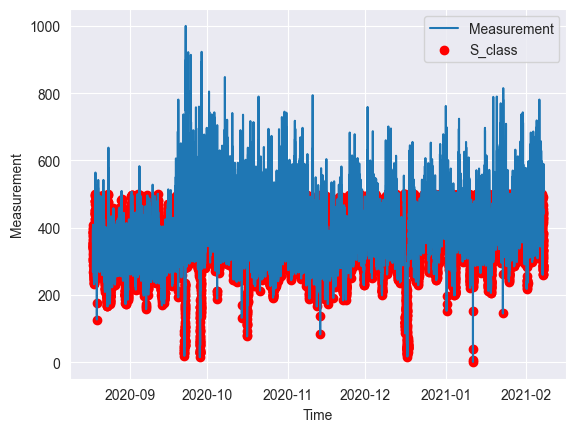

In [153]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

trainingArray =  np.array([i for i in trainingData.iloc[:, 1]])

scaler = StandardScaler()
z_scores = scaler.fit_transform(trainingArray.reshape(-1, 1))

trainingData['z_scores'] = scaler.fit_transform(trainingData['Measure'].values.reshape(-1, 1))
threshold = 1.1
trainingData['S_class'] = trainingData['z_scores'] < threshold
anomalies = z_scores > threshold


plt.plot(trainingData['EventTime'], trainingData['Measure'], label='Measurement')
plt.scatter(trainingData['EventTime'][trainingData['S_class']], trainingData['Measure'][trainingData['S_class']], c='red', label='S_class')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.show()



In [154]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score


# Calculate Z-scores
scaler = StandardScaler()
trainingData['z_score'] = scaler.fit_transform(trainingData['Measure'].values.reshape(-1, 1))

# Set the threshold based on the best threshold found earlier
best_threshold = 1.1  # Replace with the actual best threshold value calculated

# Label anomalies based on the threshold
trainingData['is_anomaly'] = (trainingData['z_score'] > best_threshold) | (trainingData['z_score'] < -best_threshold)
trainingData

,EventTime,Measure,Class,z_scores,S_class,z_score,is_anomaly
0,2020-08-17 18:30:00,269,0.0,-1.132354,True,-1.132354,True
1,2020-08-17 18:40:00,380,0.0,-0.066060,True,-0.066060,False
2,2020-08-17 18:50:00,386,0.0,-0.008422,True,-0.008422,False
3,2020-08-17 19:00:00,376,0.0,-0.104485,True,-0.104485,False
4,2020-08-17 19:10:00,374,0.0,-0.123697,True,-0.123697,False
...,...,...,...,...,...,...,...
24995,2021-02-07 18:20:00,568,0.0,1.739915,False,1.739915,True
24996,2021-02-07 18:30:00,570,0.0,1.759128,False,1.759128,True
24997,2021-02-07 18:40:00,564,0.0,1.701490,False,1.701490,True
24998,2021-02-07 18:50:00,583,0.0,1.884009,False,1.884009,True


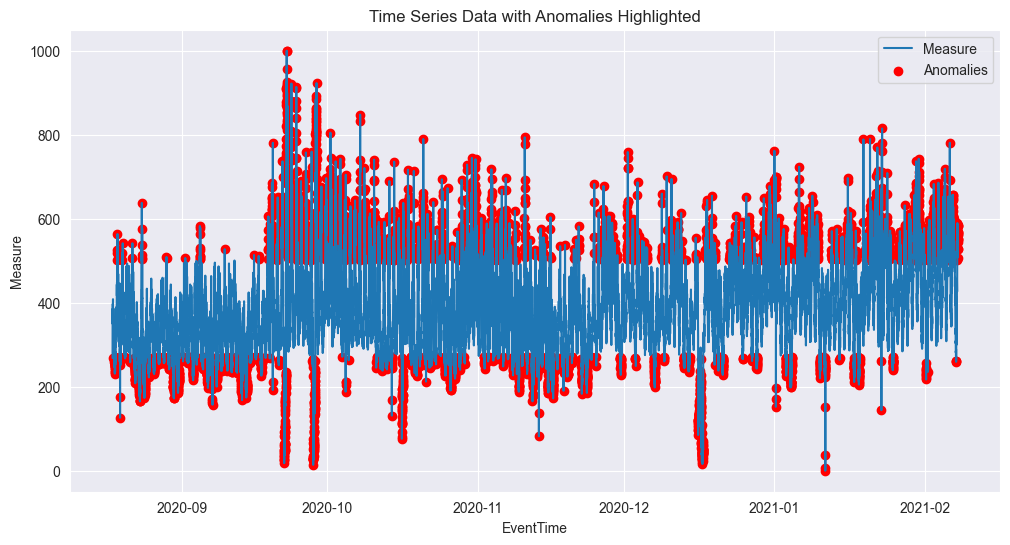

In [155]:
plt.figure(figsize=(12, 6))
plt.plot(trainingData['EventTime'], trainingData['Measure'], label='Measure')

# Highlight anomalies
anomaly_indices = trainingData[trainingData['is_anomaly']].index
anomaly_values = trainingData[trainingData['is_anomaly']]['Measure']
plt.scatter(trainingData['EventTime'][anomaly_indices], anomaly_values, c='red', marker='o', label='Anomalies')

plt.xlabel('EventTime')
plt.ylabel('Measure')
plt.legend()
plt.title('Time Series Data with Anomalies Highlighted')
plt.grid(True)
plt.show()



In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

dataAll = pd.concat([trainingData, testingData])

# Calculate Z-scores
scaler = StandardScaler()
dataAll['z_score'] = scaler.fit_transform(dataAll['Measure'].values.reshape(-1, 1))

# Set the upper and lower threshold based on the best threshold found earlier
best_threshold = 1.0  # Replace with the actual best threshold value

# Label anomalies based on the upper and lower thresholds
dataAll['is_anomaly'] = (dataAll['z_score'] > best_threshold) | (dataAll['z_score'] < -best_threshold)

# Split the data into features and target
X = dataAll['z_score'].values.reshape(-1, 1)  # Features (Z-scores)
y = dataAll['is_anomaly'].astype(int)  # Target (0 for normal, 1 for anomaly)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# Train an SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# Make predictions and evaluate the model
svm_predictions = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4439
           1       1.00      1.00      1.00      2164

    accuracy                           1.00      6603
   macro avg       1.00      1.00      1.00      6603
weighted avg       1.00      1.00      1.00      6603



In [20]:
#RF
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4439
           1       1.00      1.00      1.00      2164

    accuracy                           1.00      6603
   macro avg       1.00      1.00      1.00      6603
weighted avg       1.00      1.00      1.00      6603



Classification Metrics:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4439
     Anomaly       1.00      1.00      1.00      2164

    accuracy                           1.00      6603
   macro avg       1.00      1.00      1.00      6603
weighted avg       1.00      1.00      1.00      6603



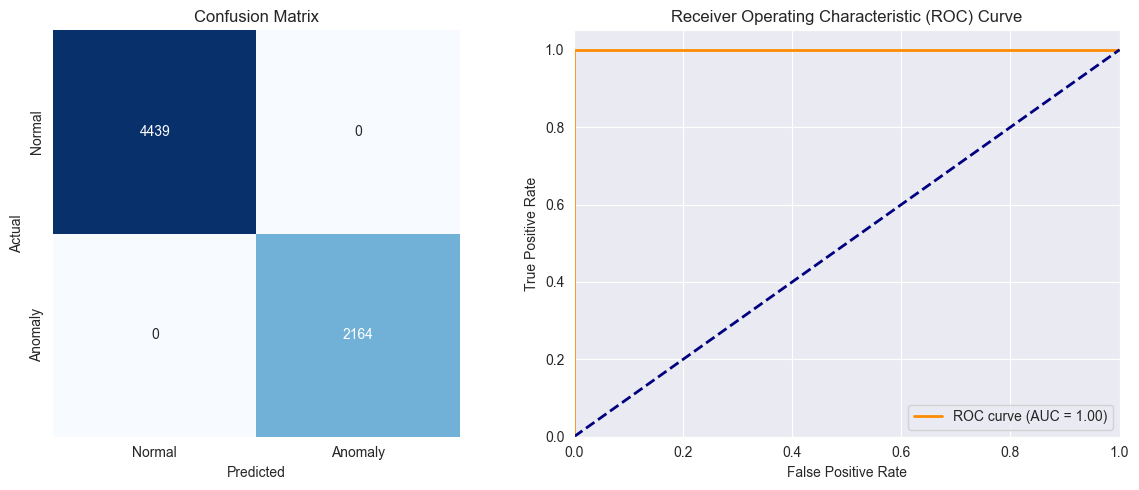

In [24]:
# Calculate classification metrics (accuracy, precision, recall, F1-score)
classification_metrics = classification_report(y_test, rf_predictions, target_names=['Normal', 'Anomaly'])

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Print classification metrics
print("Classification Metrics:")
print(classification_metrics)

plt.tight_layout()
plt.show()

Classification Metrics:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4439
     Anomaly       1.00      1.00      1.00      2164

    accuracy                           1.00      6603
   macro avg       1.00      1.00      1.00      6603
weighted avg       1.00      1.00      1.00      6603



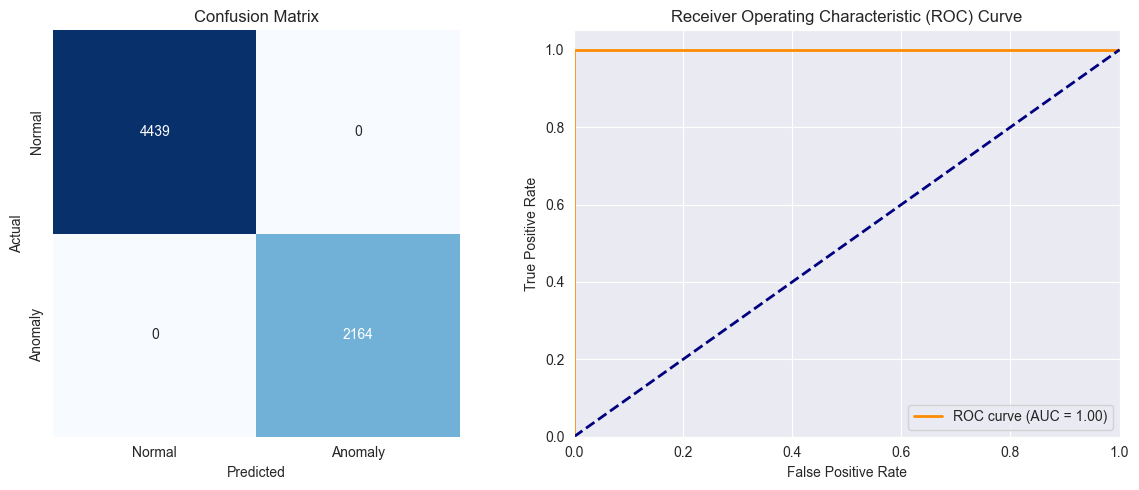

In [31]:
# Calculate classification metrics (accuracy, precision, recall, F1-score)
classification_metrics = classification_report(y_test, svm_predictions, target_names=['Normal', 'Anomaly'])

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, svm_model.decision_function(X_test))
roc_auc = auc(fpr, tpr)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Print classification metrics
print("Classification Metrics:")
print(classification_metrics)

plt.tight_layout()
plt.show()

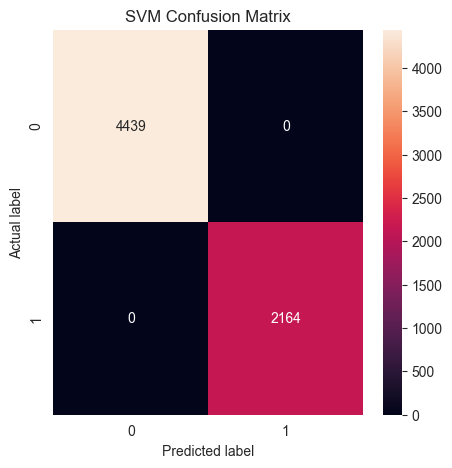

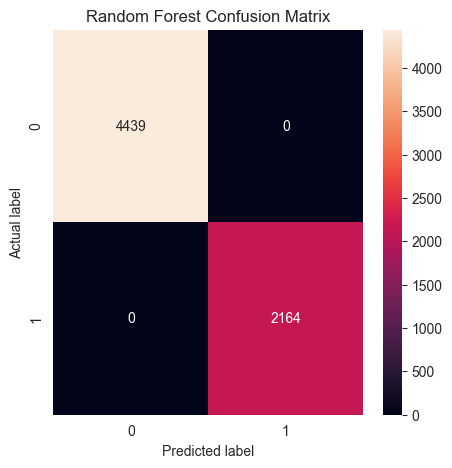

In [32]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting confusion matrix for SVM and Random Forest
plot_confusion_matrix(y_test, svm_predictions, title='SVM Confusion Matrix')
plot_confusion_matrix(y_test, rf_predictions, title='Random Forest Confusion Matrix')


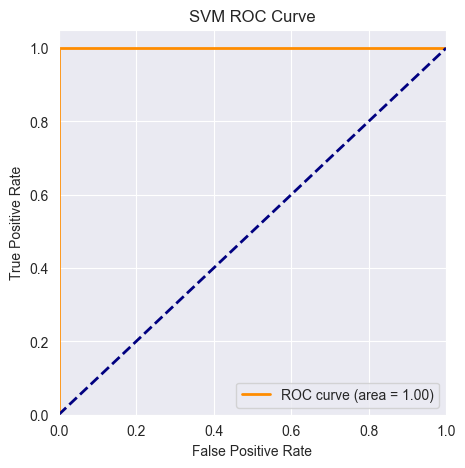

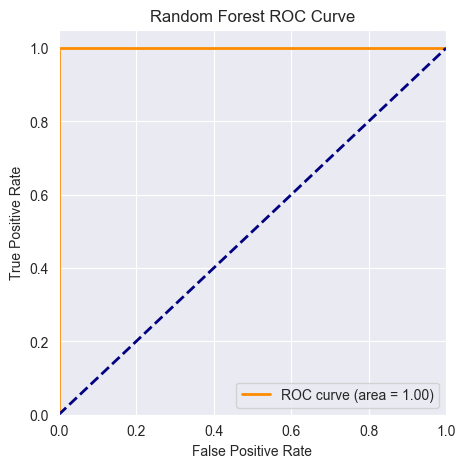

In [33]:
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plotting ROC curve for SVM and Random Forest
svm_scores = svm_model.decision_function(X_test)
rf_scores = rf_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, svm_scores, title='SVM ROC Curve')
plot_roc_curve(y_test, rf_scores, title='Random Forest ROC Curve')

In [34]:
def plot_predictions_scatter(y_true, y_pred, title='Predictions vs Actual'):
    plt.figure(figsize=(10,6))

    # Scatter plot
    plt.scatter(range(len(y_true)), y_true, color='blue', alpha=0.5, label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, color='green', alpha=0.3, label='Predicted')

    plt.title(title)
    plt.ylabel('Class')
    plt.xlabel('Sample Index')
    plt.yticks([0, 1], ['0 (Normal)', '1 (Anomaly)'])
    plt.legend()
    plt.grid(True)
    plt.show()


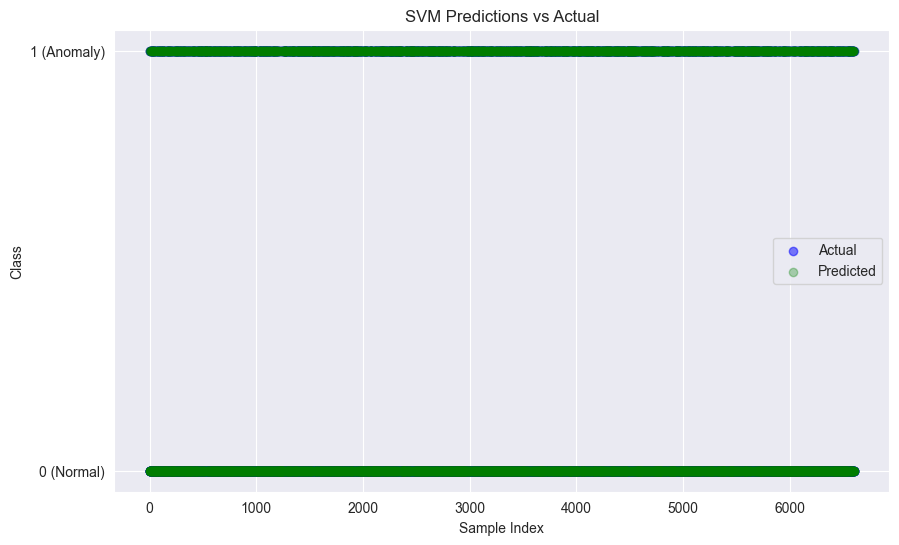

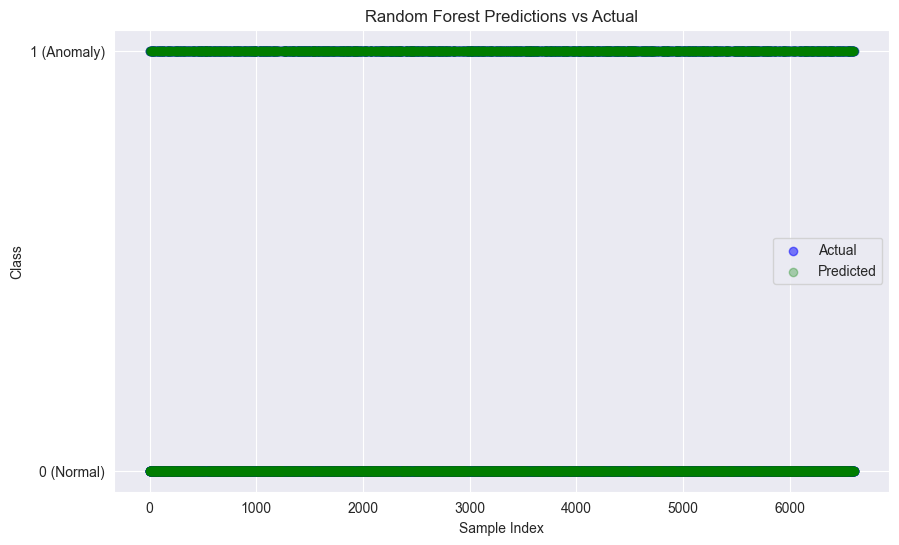

In [35]:
# Plotting Predictions vs Actual for SVM
plot_predictions_scatter(y_test, svm_predictions, title='SVM Predictions vs Actual')

# Plotting Predictions vs Actual for Random Forest
plot_predictions_scatter(y_test, rf_predictions, title='Random Forest Predictions vs Actual')